# Seminar #2: Levenshtein distance, WER

Over the past decade, there has been a multiple improvements in the quality of ASR 📈 . But in what units and how the ASR quality is measured?

Word (Character, Phoneme) Error Rate (WER/CER/PER) – are the most popular metrics, which try to approximate how we perceive errors in the speech we hear.

![human performance wer](https://awni.github.io/images/speech-recognition/wer.svg)

In this seminar, we will try out one of the edit distances: the Levenshtein distance, we'll implement it (naively and more optimally), discuss the issue of computational complexity a little, and then we'll show how this distance can be turned into an ASR system quality metric.

## Levenshtein distance

Consider the sequence of elements (for example, strings are sequences of characters). In fact, the algorithm easily generalizes to sequences of any elements that can be compared for equality, such as sequences of strings (e.g. list of words).

Assume that the following operations can be performed on the sequence:
* **insertion**: cat → ca<font color='green'>s</font>t,
* **deletion**: ca<font color='red'>s</font>t → cat,
* **substitution**: c<font color='blue'>a</font>t → c<font color='blue'>u</font>t,

and suppose they have equal *costs*. So these operations are enough to translate an arbitrary sequence into any other one. But how to find the optimal way to do this transformation. And what is the 

### Algorithm definition

Levenshtein distance – the number inserts, deletions, and substitutions are required to get a second sequence from one sequence.

$$
\mathrm{L}(a, b) = 
\begin{cases}
    |a|,& \text{if } |b| = 0, ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# second sequence is empty} \\
    |b|,& \text{if } |a| = 0, ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# first sequence is empty} \\
    \mathrm{L}(\mathrm{tail}(a), \mathrm{tail}(b)),& \text{if } \mathrm{head}(a) = \mathrm{head}(b), ~ ~ \text{# first elements of two sequencies are equal} \\
    1 + min 
    \begin{cases} 
        \mathrm{L}(\mathrm{tail}(a), b), ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# deletion from first sequence} \\ 
        \mathrm{L}(a, \mathrm{tail}(b)), ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# insertion into first sequence} \\ 
        \mathrm{L}(\mathrm{tail}(a), \mathrm{tail}(b)); ~ ~ ~ ~ \text{# substitution}
    \end{cases} & \text{, otherwise.}
\end{cases}
$$

As you can see, the Levenshtein distance is a metric in the mathematical sense (symmetry, positive certainty, triangle inequality).

**Question: what is the complexity of this algorithm?**

### Naïve recursive implementation (3 points)

Let's try to implement the recursive algorithm described above.

In [2]:
def levenshtein_naive(a, b):
    if not len(a) or not len(b):
        return len(a) + len(b)
    
    if a[0] == b[0]:
        return levenshtein_naive(a[1:], b[1:])
    
    l1 = levenshtein_naive(a[1:], b)
    l2 = levenshtein_naive(a, b[1:])
    l3 = levenshtein_naive(a[1:], b[1:])
    return 1 + min(l1, l2, l3)

def run_tests(fn):
    assert fn('kitten', 'sitten') == 1
    assert fn('kitten', 'sit') == 4
    assert fn('kitten', 'puppy') == 6
    assert fn('bcabac', 'cabcab') == 3
    
run_tests(levenshtein_naive)

###  Wagner–Fischer algorithm (3 points)

The complexity of the naive implementation of the Levenshtein distance algorithm is exponential. This is due to the fact that we recalculate the distances for the same suffixes more than onese! 

This can be avoided if we cache the results of calculations in the form of a matrix of distances between suffixes (more conveniently, prefixes), and fill in this matrix iteratively.

The resulting algorithm is named *Wagner–Fischer algorithm** and is an example of a dynamic programming algorithm.

Auxiliary function for drawing this matrix:

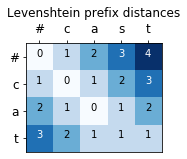

In [3]:
from typing import List, Iterable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


def plot_matrix(matrix, row_names, column_names, path=None, mods=None):
    row_names = ['#'] + list(row_names)
    column_names = ['#'] + list(column_names)
    matrix = np.array(matrix)
    
    plt.figure(figsize=(len(column_names) / 2, len(row_names) / 2))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title("Levenshtein prefix distances")
    
    r = 0 if max(map(len, row_names + column_names)) < 3 else 45
    plt.gca().xaxis.tick_top()
    plt.xticks(range(len(column_names)), column_names, fontsize=12, rotation=r)
    plt.yticks(range(len(row_names)), row_names, fontsize=12, rotation=r)

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            kwargs = {
                'color': "white" if matrix[i, j] > matrix.max() / 2 else "black",
                'horizontalalignment': 'center'
            }
            plt.text(j, i, "{:,}".format(matrix[i, j]), **kwargs)
    
    if path is not None:
        for (i, j), mod in zip(path, mods):
            colors = {
                'same': '#888888',
                'subst': '#0000ff',
                'del': '#ff0000',
                'insert': '#00ff00'
            }
            
            rect = patches.Rectangle(
                (j - 0.45, i - 0.45), 0.9, 0.9, 
                edgecolor=colors[mod], facecolor='none', linewidth=2)
            plt.gca().add_patch(rect)
            
    plt.show()


plot_matrix([
    [0, 1, 2, 3, 4],
    [1, 0, 1, 2, 3],
    [2, 1, 0, 1, 2],
    [3, 2, 1, 1, 1]
], 'cat', 'cast')

**Implement** the `levenshtein_distance_matrix` function, which returns **the distance matrix between the prefixes of the two sequences**. The lower-right element of this matrix is the distance between the prefixes that are equal to the original sequences.

It is necessary to fill in this matrix line by line: for a new element of this matrix, it is enough to know only its neighbors to the left, top, and left-top.

Also we will prepend an element denoting an **empty prefix** to the sequences – this is done in order to initialize the initial boundary values (initialize the first row and the first column of the matrix with the index values).

$$
\mathrm{L}_{a, b}(i, j) = 
\begin{cases}
    max(i, j),& \text{if } min(i, j) = 0 \\
    min 
    \begin{cases} 
        \mathrm{L}_{a, b}(i-1, j)+1, ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# deletion from first sequence} \\ 
        \mathrm{L}_{a, b}(i, j-1)+1, ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{# insertion into first sequence} \\ 
        \mathrm{L}_{a, b}(i-1, j-1) + \delta(a_i = a_j); ~ ~ ~ ~ \text{# substitution}
    \end{cases} & \text{, otherwise.}
\end{cases}
$$

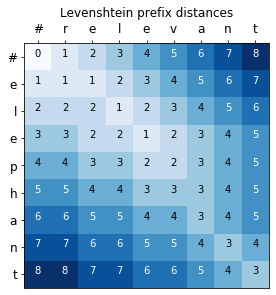

In [6]:
def levenshtein_distance_matrix(a: Iterable, b: Iterable) -> np.ndarray:
    a = ['#'] + list(a)
    b = ['#'] + list(b)
    n = len(a)
    m = len(b)
    d = np.zeros((n, m), dtype=int)
    
    d[0, :] = np.arange(m)
    d[:, 0] = np.arange(n)
    
    for i in range(1, n):
        for j in range(1, m):
            d[i, j] = min(d[i - 1, j] + 1, d[i, j - 1] + 1, d[i - 1, j - 1] + (a[i] != b[j]))
    return d

def levenshtein_dp(a: Iterable, b: Iterable) -> int:
    return levenshtein_distance_matrix(a, b)[-1, -1]

# first, second = 'sunday', 'saturday'
first, second = 'elephant', 'relevant'
plot_matrix(levenshtein_distance_matrix(first, second), first, second)

def run_tests(fn):
    assert fn('kitten', 'sitten') == 1
    assert fn('kitten', 'sit') == 4
    assert fn('kitten', 'puppy') == 6
    assert fn('bcabac', 'cabcab') == 3

    import random
    for _ in range(100):
        first = "".join([random.choice('abc') for _ in range(random.choice(range(3, 10)))])
        second = "".join([random.choice('abc') for _ in range(random.choice(range(3, 10)))])
        assert fn(first, second) == levenshtein_naive(first, second)
        
# lets check our implementation on random sequences
run_tests(levenshtein_dp)

### Backtrace (3 points)

To understand what insertions, deletions and substitutions were made on the original sequence, you can do a backtrace on the resulting matrix. 

Let's consider the first sequence as the original one, abd we will call the deletions and inserts relative to it.

**Implement** the `backtrace` function, based on the construction logic `levenshtein_distance_matrix`:
* write the path to the variable `path` – the list of the coordinates of the matrix cells that lie on the optimal path through the matrix;
* and in the `mods` variable, write down the modifications that we make on the original sequence:
    * `same` - leaving the element unchanged
    * `subst` - replacing the element
    * `del` - deleting the element
    * `insert` - inserting the element

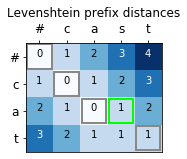

In [7]:
plot_matrix([
    [0, 1, 2, 3, 4],
    [1, 0, 1, 2, 3],
    [2, 1, 0, 1, 2],
    [3, 2, 1, 1, 1]
],
    'cat', 'cast', 
    [(0, 0), (1, 1), (2, 2), (2, 3), (3, 4)], 
    ['same', 'same', 'same', 'insert', 'same'])

In [26]:
A = np.arange(9).reshape((3, 3))
A[np.array([1, 2])]

array([[3, 4, 5],
       [6, 7, 8]])

In [29]:
def backtrace(d):
    path = [np.array([d.shape[0]-1, d.shape[1]-1])]
    mods = []
    
    while (path[-1] != np.array([0, 0])).any():
        i, j = path[-1]
        if not i:
            path.append(np.array([i, j-1]))
            mods.append("insert")
            continue
        if not j:
            path.append(np.array([i-1, j]))
            mods.append("del")
            continue
            
        if d[i, j] == d[i-1, j-1]:
            path.append(np.array([i-1, j-1]))
            mods.append("same")
            continue

        next_paths = [
            np.array([i-1, j-1]),
            np.array([i, j-1]),
            np.array([i-1, j])
        ]
        next_mods = [
            "subst",
            "insert",
            "del"
        ]
        d_values = [d[next_path[0], next_path[1]] for next_path in next_paths]

        min_i = np.argmin(d_values)

        path.append(next_paths[min_i])
        mods.append(next_mods[min_i])
        
    return path, mods

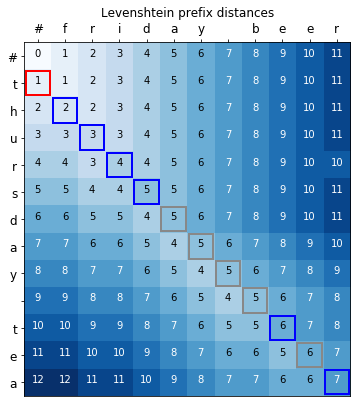

In [30]:
first, second = 'thursday tea', 'friday beer'

path, mods = backtrace(levenshtein_distance_matrix(first, second))
plot_matrix(levenshtein_distance_matrix(first, second), first, second, path, mods)

Let's try applying the Levenshtein distance to a sequence of words, not characters.

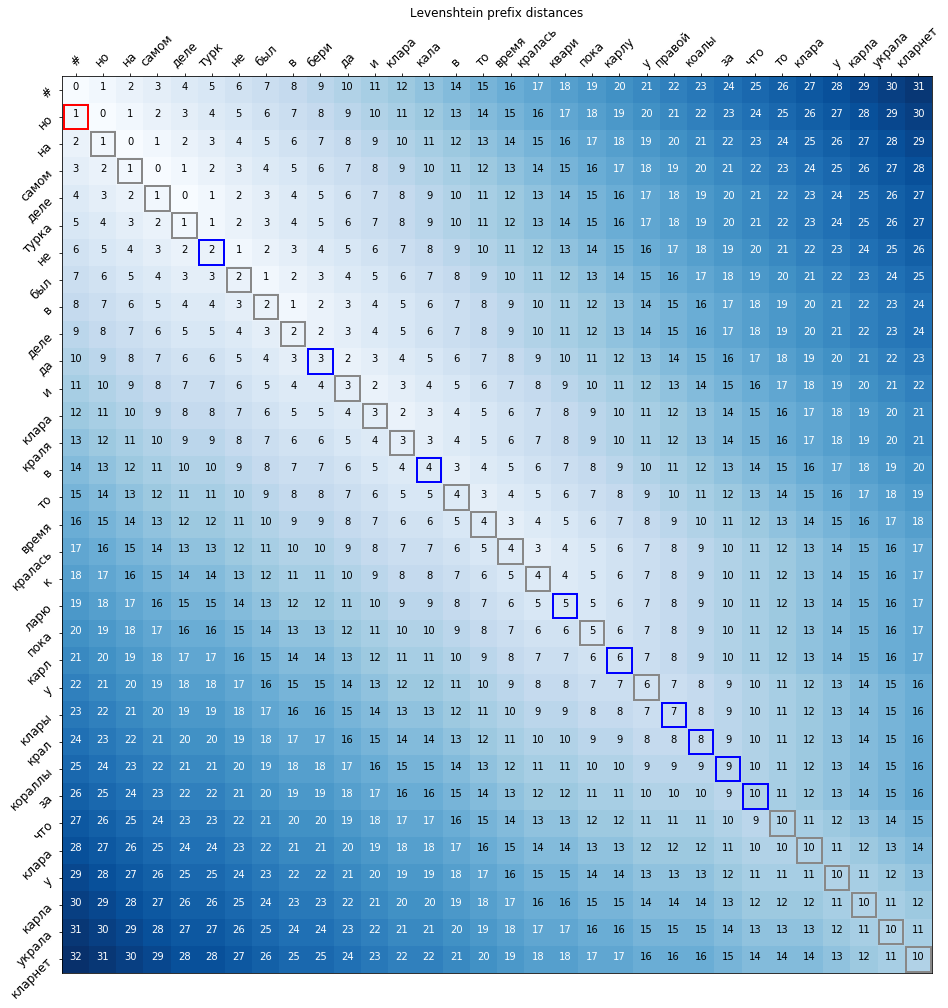

In [31]:
first = "но на самом деле турка не был в деле да и клара краля в то время кралась к ларю пока карл у клары крал кораллы за что клара у карла украла кларнет".split()
second = "но на самом деле турк не был в бери да и клара кала в то время кралась квари пока карлу у правой коалы за что то клара у карла украла кларнет".split()

path, mods = backtrace(levenshtein_distance_matrix(first, second))
plot_matrix(levenshtein_distance_matrix(first, second), first, second, path, mods)

In [32]:
D = (np.array(mods) == 'del').sum()
S = (np.array(mods) == 'subst').sum()
I = (np.array(mods) == 'insert').sum()
print(f"S: {S}")
print(f"I: {I}")
print(f"D: {D}")

S: 9
I: 0
D: 1


## Error rate

Suppose we have our reference sequence, relative to which we want to calculate the recognition error.

**Why do you think the Levenshtein distance is not suitable for measuring the quality of the ASR system?**

Because the number of tokens in sentence can be different. Therefore, we need to normalize the Levenshtein distance by the length of the reference.

### Definition

Word (character, phoneme) error rate can then be computed as:

$$
\mathrm{WER} = \frac{\mathrm{S} + \mathrm{I} + \mathrm{D}}{\mathrm{N}}, \text{where:} \\
\text{S is the number of substitutions,} \\
\text{I is the number of insertions,} \\
\text{D is the number of deletions,} \\
\text{N is the length of reference.}
$$

### WER vs CER vs PER (1 point)

Implement the `error_rate` function, which will calculate the prediction error for a given sequence of tokens (words, characters or phonemes) by formula above.

In [34]:
def error_rate(reference: Iterable, predicted: Iterable) -> float:
    return levenshtein_dp(reference, predicted)

first = "но на самом деле турка не был в деле да и клара краля в то время кралась к ларю пока карл у клары крал кораллы за что клара у карла украла кларнет"
second = "но на самом деле турк не был в бери да и клара кала в то время кралась квари пока карлу у правой коалы за что то клара у карла украла кларнет"
print('WER:', np.round(error_rate(first.split(), second.split()), 4))
print('CER:', np.round(error_rate(first, second), 4))

first = "n o <space> n ɐ <space> s a+ m ə m <space> dʲ e+ lʲ e <space> t u+ r k ə <space> nʲ e <space> b ɨ+ lˠ <space> f <space> dʲ e+ lʲ e <space> d ɐ <space> ɪ <space> k lˠ a+ r ə <space> k r a+ lʲ ə <space> f <space> t ɐ <space> v rʲ e+ mʲ ə <space> k r a+ lˠ ə sʲ <space> k <space> lˠ ɐ rʲ u+ <space> p ɐ k a+ <space> k a+ r lˠ <space> ʊ <space> k lˠ a+ r ɨ <space> k r a+ lˠ <space> k ɐ r a+ lˠ ɨ <space> z ɐ <space> t͡ɕ t ɐ <space> k lˠ a+ r ə <space> ʊ <space> k a+ r lˠ ə <space> ʊ k r a+ lˠ ə <space> k lˠ ɐ r nʲ e+ t"
second = "n o <space> n ɐ <space> s a+ m ə m <space> dʲ e+ lʲ e <space> t u+ r k <space> nʲ e <space> b ɨ+ lˠ <space> f <space> bʲ e+ rʲ ɪ <space> d ɐ <space> ɪ <space> k lˠ a+ r ə <space> k a+ lˠ ə <space> f <space> t ɐ <space> v rʲ e+ mʲ ə <space> k r a+ lˠ ə sʲ <space> k v ɐ rʲ i+ <space> p ɐ k a+ <space> k a+ r lˠ ʊ <space> ʊ <space> p r a+ v ə j <space> k ɐ a+ lˠ ɨ <space> z ɐ <space> t͡ɕ t ɐ <space> t ɐ <space> k lˠ a+ r ə <space> ʊ <space> k a+ r lˠ ə <space> ʊ k r a+ lˠ ə <space> k lˠ ɐ r nʲ e+ t"
print('PER:', np.round(error_rate(first.split(), second.split()), 4))

WER: 10
CER: 24
PER: 23
